In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/features_3_sec.csv')

In [3]:
# Identify Features and Target Label
y = data['label']
X = data.drop(columns = ['label','filename','length'])


In [4]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)


X_dev shape: (7992, 57)
X_test shape: (1998, 57)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
model_rf = RandomForestClassifier()
model_rf.fit(X_dev, y_dev)
predsDevrf = model_rf.predict(X_dev)
predsTestrf = model_rf.predict(X_test)

In [6]:
testrf_score =  accuracy_score(y_test, predsTestrf)
devrf_score = accuracy_score(y_dev, predsDevrf)

In [7]:
print("Classification Score for Random Forest on Dev dataset:\n")
print("Dev Score : ", devrf_score)
print(classification_report(y_dev, predsDevrf))
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", testrf_score)
print(classification_report(y_test, predsTestrf))

Classification Score for Random Forest on Dev dataset:

Dev Score :  0.9991241241241241
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       808
   classical       1.00      1.00      1.00       811
     country       1.00      1.00      1.00       786
       disco       1.00      1.00      1.00       792
      hiphop       1.00      1.00      1.00       797
        jazz       1.00      1.00      1.00       777
       metal       0.99      1.00      1.00       813
         pop       1.00      1.00      1.00       796
      reggae       1.00      1.00      1.00       817
        rock       1.00      0.99      1.00       795

    accuracy                           1.00      7992
   macro avg       1.00      1.00      1.00      7992
weighted avg       1.00      1.00      1.00      7992

--------------------------------------------------------
Classification Score for Random Forest on Test dataset:

Test Score : 0.8663663663663663
       

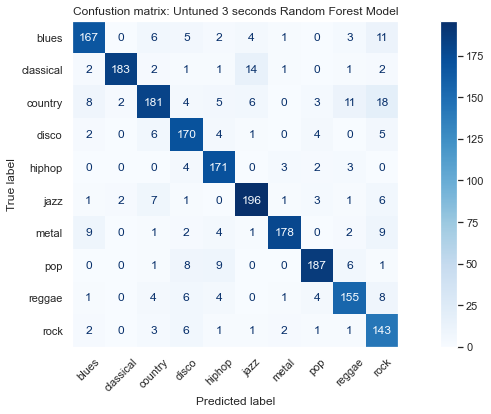

Accuracy : 0.87
Macro F-1 Score : 0.87


In [8]:
# Evaluate Model on Test set
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(predsTestrf, y_test, class_labels, 'Confustion matrix: Untuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:

parameters = {'min_samples_split': np.linspace(10,100,5,dtype=int),
              'n_estimators': np.linspace(50,200,5,dtype=int),
             'bootstrap': [True]}

print(parameters)

{'min_samples_split': array([ 10,  32,  55,  77, 100]), 'n_estimators': array([ 50,  87, 125, 162, 200]), 'bootstrap': [True]}


In [ ]:
tune_rf = GridSearchCV(estimator = model_rf, param_grid = parameters, cv = 5)
tune_rf.fit(X_dev, y_dev)

In [ ]:
print("Best Score :", tune_rf.best_score_)
print("Best Parameters :",tune_rf.best_params_)

In [ ]:
predsDevrf_tuned = tune_rf.predict(X_dev)
predsTestrf_tuned = tune_rf.predict(X_test)

print("Score on Dev data for RF using GridSearchCV:", accuracy_score(y_dev, predsDevrf_tuned))
print("Score on Test data for RF using GridSearchCV:",accuracy_score(y_test, predsTestrf_tuned))

In [ ]:
# Evaluate Model on Test set
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(predsTestrf_tuned, y_test, class_labels, 'Confustion matrix: Tuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

In [ ]:
## Plot top 3 Important Features of tuned model

In [ ]:
feature_imp_rf = tune_rf.best_estimator_.feature_importances_
final_list_rf = zip(feature_imp_rf,X_dev.columns)
res_rf = sorted(final_list_rf, key = lambda x: x[0])
res_rf = res_rf[-3:]

plt.bar(range(len(res_rf)),[val[0] for val in res_rf],align='center')
plt.xticks(range(len(res_rf)),[val[1] for val in res_rf])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

### Dimensionality reduction of data using PCA

In [ ]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

In [ ]:
pca_final.head()

In [ ]:
# from sklearn.preprocessing import OrdinalEncoder
# encoder  = OrdinalEncoder()
# encoder.fit(pca_final.iloc[:,10].reshape(-1, 1))
# y_train_encoded = encoder.transform(pca_final.iloc[:,10])

### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [ ]:
model_pca = RandomForestClassifier(max_depth=2, n_estimators=1000)
model_pca.fit(pca_final.iloc[:,:30], pca_final.iloc[:,30])
pcaTrainrf = model_pca.predict(pca_data)
pcaTestrf = model_pca.predict(pca_data_test)

In [ ]:
pcatestrf_score =  accuracy_score(y_test, pcaTestrf)
pcarf_score = accuracy_score(y_dev, pcaTrainrf)

In [ ]:
print("Classification Score for Random Forest on Train dataset:\n")
print("Train Score : ", pcarf_score)
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", pcatestrf_score)

In [ ]:
# Evaluate Model
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(pcaTestrf, y_test, class_labels, 'Confustion Matrix: PCA - Untuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [ ]:
pca_final.iloc[:,:30]

In [ ]:
model_pca_tuned = tune_rf
model_pca_tuned.fit(pca_final.iloc[:,:30], pca_final.iloc[:,30])
pcaTrainrf_tuned = model_pca_tuned.predict(pca_data)
pcaTestrf_tuned = model_pca_tuned.predict(pca_data_test)

In [ ]:
pcatestrf_score =  accuracy_score(y_test, pcaTestrf)
pcarf_score = accuracy_score(y_dev, pcaTrainrf)

In [ ]:
print("Classification Score for Random Forest on Train dataset:\n")
print("Train Score : ", pcarf_score)
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", pcatestrf_score)

In [ ]:
# Evaluate Model
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(pcaTestrf, y_test, class_labels, 'Confustion Matrix: PCA - Tuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

**Ans:** As we see due to the lesser number of data, PCA instead of helping in the improvement of the accuracy or the model learning by reducing the dimensions ("the curse of dimensionality"), makes the model worse. 